# This script fits a linear regression for a single LR pair

In [1]:
import numpy as np
import csv
import pickle
import matplotlib
import math
import pandas as pd
import matplotlib
from sklearn.utils import resample
from sklearn import linear_model
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import Counter

In [2]:
def readCsv(x):
  """Parse file."""
  #colNames = ["method", "benchmark", "start", "end", "time", "memory"]
  df = pd.read_csv(x, sep=",")

  return df

def preprocessDf(df):
  """Transform ligand and receptor columns."""
  df["ligand-receptor"] = df["ligand"] + '-' + df["receptor"]
  df["component"] = df["component"] #.astype(str).str.zfill(2)

  return df

In [3]:
# Load subtype label
# subtype_label_file='/Users/victoriagao/local_docs/schwartz_data/PDAC_64630_subtype.csv'
subtype_label_file='/Users/victoriagao/Documents/MSc/Schwartz_lab/experiment_data/Deisha/PDAC_64630/fractional_abundances_by_spot.csv'
subtype_abundance_df = readCsv(subtype_label_file)
# subtype_label=[]
# with open(subtype_label_file) as file:
#     csv_file = csv.reader(file, delimiter=",")
#     for line in csv_file:
#         subtype_label.append(line)

# barcode_subtype=dict()
# for i in range(1,len(subtype_label)):
#     barcode_subtype[subtype_label[i][0]]= subtype_label[i][1]

# Load NEST output 
df = readCsv("/Users/victoriagao/local_docs/NEST/output/From_Fatema/NEST_combined_output_PDAC_64630.csv")
# df = readCsv("/Users/victoriagao/local_docs/NEST/output/From_Fatema/exp1_C1_top20percent.csv")
output_processed = preprocessDf(df)

In [4]:
output_processed

,from_cell,to_cell,ligand,receptor,attention_score,component,from_id,to_id,ligand-receptor
0,ACGCGCTACACAGGGT-1,AAACCGGGTAGGTACC-1,LGALS3,NPTN,0.911919,2,132,0,LGALS3-NPTN
1,TCTTACTTATGCCTCT-1,AAAGTGTGATTTATCT-1,FN1,RPSA,0.929988,6,1228,9,FN1-RPSA
2,AGTCTCACAAGACTAC-1,AAATTGATAGTCCTTT-1,PTPRF,RACK1,0.911508,10,228,15,PTPRF-RACK1
3,GTGGGCTTAGACACAC-1,AACAACTGGTAGTTGC-1,FN1,RPSA,0.923395,11,992,17,FN1-RPSA
4,CCACAGTACCCATCCT-1,AACCGCTAAGGGATGC-1,FN1,RPSA,0.929303,16,425,23,FN1-RPSA
...,...,...,...,...,...,...,...,...,...
1088,AACGTCAGACTAGTGG-1,TTGGCTCGCATGAGAC-1,TGFB1,EGFR,0.839991,17,31,1389,TGFB1-EGFR
1089,AGATTATAGGACGTTT-1,TTGTAATCCGTACTCG-1,TGFB1,ITGB5,0.829314,9,184,1394,TGFB1-ITGB5
1090,AGATTATAGGACGTTT-1,TTGTAATCCGTACTCG-1,TGFB1,SDC2,0.855152,9,184,1394,TGFB1-SDC2
1091,GAGAGGTGCATTCTGG-1,TTGTTTCCATACAACT-1,TGFB1,EGFR,0.830097,2,715,1404,TGFB1-EGFR


In [5]:
subtype_abundance_df

,SpotID,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
0,CTACTATCATAGGTTT-1,0.5,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GAAGAACGGTGCAGGT-1,0.5,0.166667,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TTCTAGGCCAATTGTG-1,0.2,0.000000,0.200000,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TGTGTTCGTATCCAAG-1,0.2,0.000000,0.200000,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0
4,CGAGCGTTGATCAGCC-1,0.5,0.250000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,CGTGCAGACTGGGACA-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1402,AGTTCCTATTTATGTT-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1403,TTGCGTCGGCCAACCG-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1404,GCTGCACGGTTTCTTA-1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Build feature matrix

In [6]:
### Merge NEST output with subtype label, and filter out the spots that are not in the subtype label
matched_spots_df = pd.merge(output_processed, subtype_abundance_df, left_on='from_cell', right_on='SpotID')
# matched_spots_df

In [7]:
# filter out the LR that only appeared once
matched_spots_df = matched_spots_df[matched_spots_df['ligand-receptor'].duplicated(keep=False)] 
# Take only top 90% LR by frequency
lr_counts = matched_spots_df['ligand-receptor'].value_counts()
threshold = lr_counts.quantile(0.90)  # gives the value at the 80th percentile
top_percent_lrs = lr_counts[lr_counts >= threshold].index
matched_spots_df = matched_spots_df[matched_spots_df['ligand-receptor'].isin(top_percent_lrs)]
# Delete some columns
matched_spots_df = matched_spots_df.drop(columns=['to_cell', 'ligand', 'receptor', 'attention_score', 'component', 'from_id','to_id','SpotID'])

In [8]:
matched_spots_df

,from_cell,ligand-receptor,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast
1,TCTTACTTATGCCTCT-1,FN1-RPSA,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,1.00,0.0,0.000000,0.0,0.0
2,AGTCTCACAAGACTAC-1,PTPRF-RACK1,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,1.00,0.0,0.000000,0.0,0.0
3,GTGGGCTTAGACACAC-1,FN1-RPSA,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
4,CCACAGTACCCATCCT-1,FN1-RPSA,0.0,0.250000,0.000000,0.000000,0.0,0.000000,0.0,0.25,0.0,0.0,0.50,0.0,0.000000,0.0,0.0
6,GAATTTCTCGCTGCAG-1,FN1-RPSA,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1074,TTCAACGACCCGACCG-1,LGALS3-ITGB4,0.0,0.222222,0.444444,0.000000,0.0,0.333333,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
1083,CACAGCTAGGGAGTGA-1,PTPRF-MET,0.0,0.333333,0.000000,0.166667,0.5,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
1084,TGTTTCGGTACTTCTC-1,PTPRF-MET,0.0,0.500000,0.000000,0.000000,0.0,0.333333,0.0,0.00,0.0,0.0,0.00,0.0,0.166667,0.0,0.0
1087,AACGTCAGACTAGTGG-1,TGFB1-ITGB5,0.0,0.000000,0.750000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.25,0.0,0.000000,0.0,0.0


In [9]:
# Count the occurrences of LGALS3-ITGB4 for each from_cell
fn1_RPSA_counts = matched_spots_df[matched_spots_df['ligand-receptor'] == 'FN1-RPSA'].groupby('from_cell')['ligand-receptor'].count()
counts_df = fn1_RPSA_counts.reset_index(name='# of FN1-RPSA')
# Merge the counts with the matched_spots_df and drop rows with NaN for # of FN1-RPSA
final_matrix = pd.merge(matched_spots_df, counts_df, on='from_cell', how='left').dropna(subset=['# of FN1-RPSA'])

In [10]:
final_matrix # this is the feature matrix

,from_cell,ligand-receptor,Endothelial,ClassicA,Fibroblast,Duct,Endocrine,Mixed,BasalB,NKCell,Acinar,BasalA,BPlasmaCell,ClassicB,TCell,Macrophage,Mast,# of FN1-RPSA
0,TCTTACTTATGCCTCT-1,FN1-RPSA,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.00,0.0,0.0,2.0
2,GTGGGCTTAGACACAC-1,FN1-RPSA,0.0,0.00,1.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.0
3,CCACAGTACCCATCCT-1,FN1-RPSA,0.0,0.25,0.000000,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,0.50,0.0,0.00,0.0,0.0,1.0
4,GAATTTCTCGCTGCAG-1,FN1-RPSA,0.0,0.00,1.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.0
7,GTTTGGGCTTGTGAGC-1,FN1-RPSA,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.00,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,TGATTCGTCTATCACT-1,TGFB1-ITGB5,0.0,0.00,0.500000,0.0,0.500000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.0
394,CGTGTCCCATTCGCGA-1,TGFB1-ITGB5,0.0,0.00,1.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.0
398,GCAAACCCTACATTAT-1,TGFB1-ITGB5,0.0,0.00,0.250000,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.25,0.0,0.0,1.0
405,GCAAACCCTACATTAT-1,TGFB1-ITGB5,0.0,0.00,0.250000,0.0,0.000000,0.0,0.0,0.25,0.0,0.0,0.25,0.0,0.25,0.0,0.0,1.0


In [12]:
X = final_matrix[['Endothelial','ClassicA','Fibroblast','Duct','Endocrine','Mixed','BasalB','NKCell','Acinar','BasalA','BPlasmaCell','ClassicB','TCell','Macrophage','Mast']]
y = final_matrix['# of FN1-RPSA']

### Linear Regression model

In [13]:
print(X.shape, y.shape)
print(Counter(y))

(84, 15) (84,)
Counter({1.0: 74, 2.0: 10})


In [116]:
### FIT Ordinary Least Squares without sliptting the data

# Linear regression
regr = linear_model.LinearRegression() # ordinary least squares
regr.fit(X, y)
print(regr.coef_)

[ 0.00000000e+00 -1.14049685e-01  1.92346648e-01 -5.55111512e-17
 -5.74768680e-02  1.36592334e-01  3.38892312e-02 -3.29145658e-01
  3.03576608e-18  2.77555756e-17  4.12231994e-01 -1.79015879e-42
  1.61232813e-02 -9.87418114e-02 -1.91769466e-01]


#### Try calculating the R square for Linear Regression

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [112]:
reg_nnls = linear_model.LinearRegression(positive=True)
y_pred_nnls = reg_nnls.fit(X_train, y_train).predict(X_test)
r2_score_nnls = r2_score(y_test, y_pred_nnls)
print("NNLS R2 score", r2_score_nnls)

NNLS R2 score -0.03839159957973548


In [113]:
reg_ols = linear_model.LinearRegression()
y_pred_ols = reg_ols.fit(X_train, y_train).predict(X_test)
r2_score_ols = r2_score(y_test, y_pred_ols)
print("OLS R2 score", r2_score_ols)

OLS R2 score -0.0012057485864196416


Text(0, 0.5, 'NNLS regression coefficients')

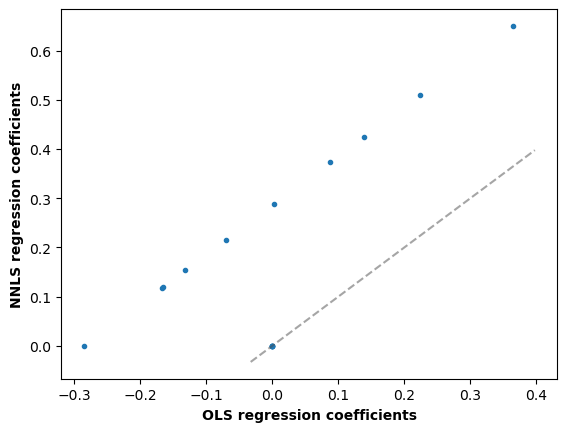

In [98]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(reg_ols.coef_, reg_nnls.coef_, linewidth=0, marker=".")

low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = max(low_x, low_y)
high = min(high_x, high_y)
ax.plot([low, high], [low, high], ls="--", c=".3", alpha=0.5)
ax.set_xlabel("OLS regression coefficients", fontweight="bold")
ax.set_ylabel("NNLS regression coefficients", fontweight="bold")

### Logistic Regression

In [16]:
# build label vector
X_log_reg = matched_spots_df[['Endothelial','ClassicA','Fibroblast','Duct','Endocrine','Mixed','BasalB','NKCell','Acinar','BasalA','BPlasmaCell','ClassicB','TCell','Macrophage','Mast']]
y_binary = ["yes" if lr == "PTPRF-RACK1" else "no" for lr in matched_spots_df["ligand-receptor"]]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_log_reg, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
print(Counter(y_train))

# build logistic model
model_log_reg = linear_model.LogisticRegression(solver='lbfgs')
model_log_reg.fit(X_train, y_train)
# model_log_reg.fit(X_log_reg, y_binary)

Counter({'no': 346, 'yes': 42})


LogisticRegression()

In [12]:
model_log_reg.coef_

array([[-0.16426638, -0.91368122, -0.67693459,  1.90313549, -1.02441014,
        -1.28784833,  0.23887955, -0.37044832, -0.14682101,  1.44271148,
         0.74080207, -0.05026039,  1.20704044, -0.37687416, -0.63360157]])

#### Try calculating the accuracy for logistic regression

In [17]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
n_scores = cross_val_score(model_log_reg, X_log_reg, y_binary, scoring='accuracy', cv=cv, n_jobs=-1) # evaluate the model and collect the scores
print('Mean Accuracy: %.4f (%.4f)' % (np.mean(n_scores), np.std(n_scores)))

# print('Mean Accuracy:', model_log_reg.score(X_log_reg, y_binary))

Mean Accuracy: 0.8930 (0.0048)


#### Build confusion matrix to calculate for sensitivity (true positive rate) for the model

In [23]:
from sklearn.metrics import confusion_matrix
# make confusion matrix
y_pred = model_log_reg.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() # extract the values from the confusion matrix
print(tn, fp, fn, tp)

['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'] ['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 

#### IGNORE BELOW

In [83]:
###### IGNORE BELOW

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)


NameError: name 'X_test' is not defined